In [1]:
from datetime import datetime
import pandas as pd
import plotly.express as px

# ====================================================
# https://pyproj4.github.io/pyproj/stable/
import pyproj

# ====================================================
# local imports
from src.bindings.coordinates_class import LLA_Coord
from src.bindings.satelliteinformation_class import SatelliteInformation
from src.bindings.timeandlocation_class import TimeAndLocation
from src.bindings.ionospherestate_class import IonosphereState
from src.indexrefractionmodels.dispersionmodels_enum import DispersionModel
from src.indexrefractionmodels.transportmodes_enum import TransportMode
from src.positional.satellitepositiongenerator import SatellitePositionGenerator
from src.raypatheffects import EstimateRayPathEffects

# ====================================================
# constants
ECEF = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
LLA = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')

In [2]:
s = '1 25544U 98067A   19343.69339541  .00001764  00000-0  38792-4 0  9991'
t = '2 25544  51.6439 211.2001 0007417  17.6667  85.6398 15.50103472202482'
name = "Test"

satelliteInformation = SatelliteInformation(name=name, s=s, t=t)
satPosGenerator = SatellitePositionGenerator(satelliteInformation)

In [3]:
# Initial Starting Point
currentDateTime = datetime(2012, 9, 15, 13, 14, 30)
sat_ECEF = satPosGenerator.estimatePosition_ECEF(currentDateTime)

# expected height, assume minimal change in position with range projection
lon_deg, lat_deg, alt_m = pyproj.transform(
    ECEF, LLA, sat_ECEF.x_m, sat_ECEF.y_m, sat_ECEF.z_m, radians=False)

event_LLA = LLA_Coord(lat_deg, lon_deg, 0.0)
timeAndLocation = TimeAndLocation(
    eventLocation_LLA=event_LLA, eventTime_UTC=currentDateTime)

/var/folders/58/1tk2h3ms7v1_2xqlx0tps9rc0000gn/T/ipykernel_5101/341162425.py:6: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon_deg, lat_deg, alt_m = pyproj.transform(


In [4]:
ionosphereState = IonosphereState(10.0, 10.0, 3.0)

# ======================================================
optimizer = EstimateRayPathEffects(
    timeAndLocation=timeAndLocation, dispersionModel=DispersionModel.X_MODEL, transportMode=TransportMode.PLASMA_MODE)
freq_Hz = 10*6

transIonosphereEffects = optimizer.estimate(
    freq_Hz=freq_Hz, satelliteInformation=satelliteInformation, ionosphereState = ionosphereState)

In [5]:
print(transIonosphereEffects.totalIonoDelay_sec)
print(transIonosphereEffects.totalIonoLoss_db)

rayStates = transIonosphereEffects.rayStates
listTmp = []
columnNames = []
for rayState in rayStates:
    tmpList = rayState.generateList()
    listTmp.append(tmpList)
    columnNames = rayState.generateColumnNames()

df = pd.DataFrame(listTmp, columns = columnNames, dtype = float)

478.7059276741901
0.0


/Users/kjohnston/RayTracing/venv/lib/python3.9/site-packages/pandas/core/construction.py:781: ComplexWarning: Casting complex values to real discards the imaginary part
  subarr = np.array(arr, dtype=dtype, copy=copy)


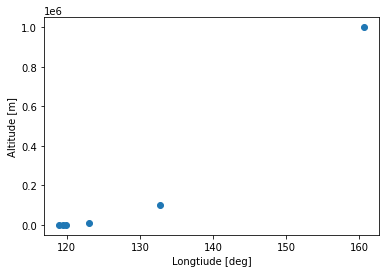

In [8]:
import matplotlib.pyplot as plt

fig = plt.scatter(df['Longitude'],  df['Altitude'])

plt.xlabel("Longtiude [deg]")
plt.ylabel("Altitude [m]")

plt.show()